---
# pRF experiment

This notebook contains an initial analysis of the pRF-data (run-2 and run-5). Each run had 3 iterations of the pRF-design, meaning we will average runs, and iterations.

In [34]:
from linescanning import utils,prf,dataset,plotting
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import signal
import os
opj = os.path.join

warnings.simplefilter('ignore')
project_dir = os.environ.get("DIR_PROJECTS")
base_dir = os.path.join(project_dir, 'hemifield')
deriv_dir = opj(base_dir, 'derivatives')

plot_vox = 359
plot_xkcd = False
fig_ext = "png"
np.set_printoptions(precision=3)


Fetch the files representing the functional data (`bold.mat` > `call_linerecon`), experiment log file `events.tsv` > `exptools2`), regressor file (`physio.txt`) and mat-file (`physio.mat`) physio files (`call_spmphysio`). `run_files` collects all these files in a list, from which we can then pick the required files and store them in their respective variable

In [2]:
# Load data
sub         = '003'
ses         = 3
task        = "task-pRF"
run         = [2,5]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
prf_new     = opj(base_dir, 'derivatives', 'prf', f"sub-{sub}", f"ses-{ses}")

if not os.path.exists(prf_new):
    os.makedirs(prf_new, exist_ok=True)

In [3]:
run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
print(func_file)

window = 19
order = 3

func = dataset.Dataset(func_file,
                       deleted_first_timepoints=0, 
                       deleted_last_timepoints=0,
                       window_size=window, # needs to be odd
                       low_pass=False,
                       poly_order=order,
                       use_bids=True,
                       verbose=True)

data = func.fetch_fmri(dtype="zscore")
avg_func = data.groupby(['subject', 't']).mean()
print(avg_func.shape)
avg_func.head()

win11_poly3 = avg_func.copy()

['/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-pRF_run-2_bold.mat', '/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-pRF_run-5_bold.mat']
DATASET

FUNCTIONAL
Preprocessing /data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-pRF_run-2_bold.mat
 Filtering strategy: 'hp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
Preprocessing /data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-pRF_run-5_bold.mat
 Filtering strategy: 'hp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]

DATASET: created
Fetching dataframe from attribute 'df_func_zscore'
(4800, 720)


AttributeError: 'Dataset' object has no attribute 'high_passed_df'

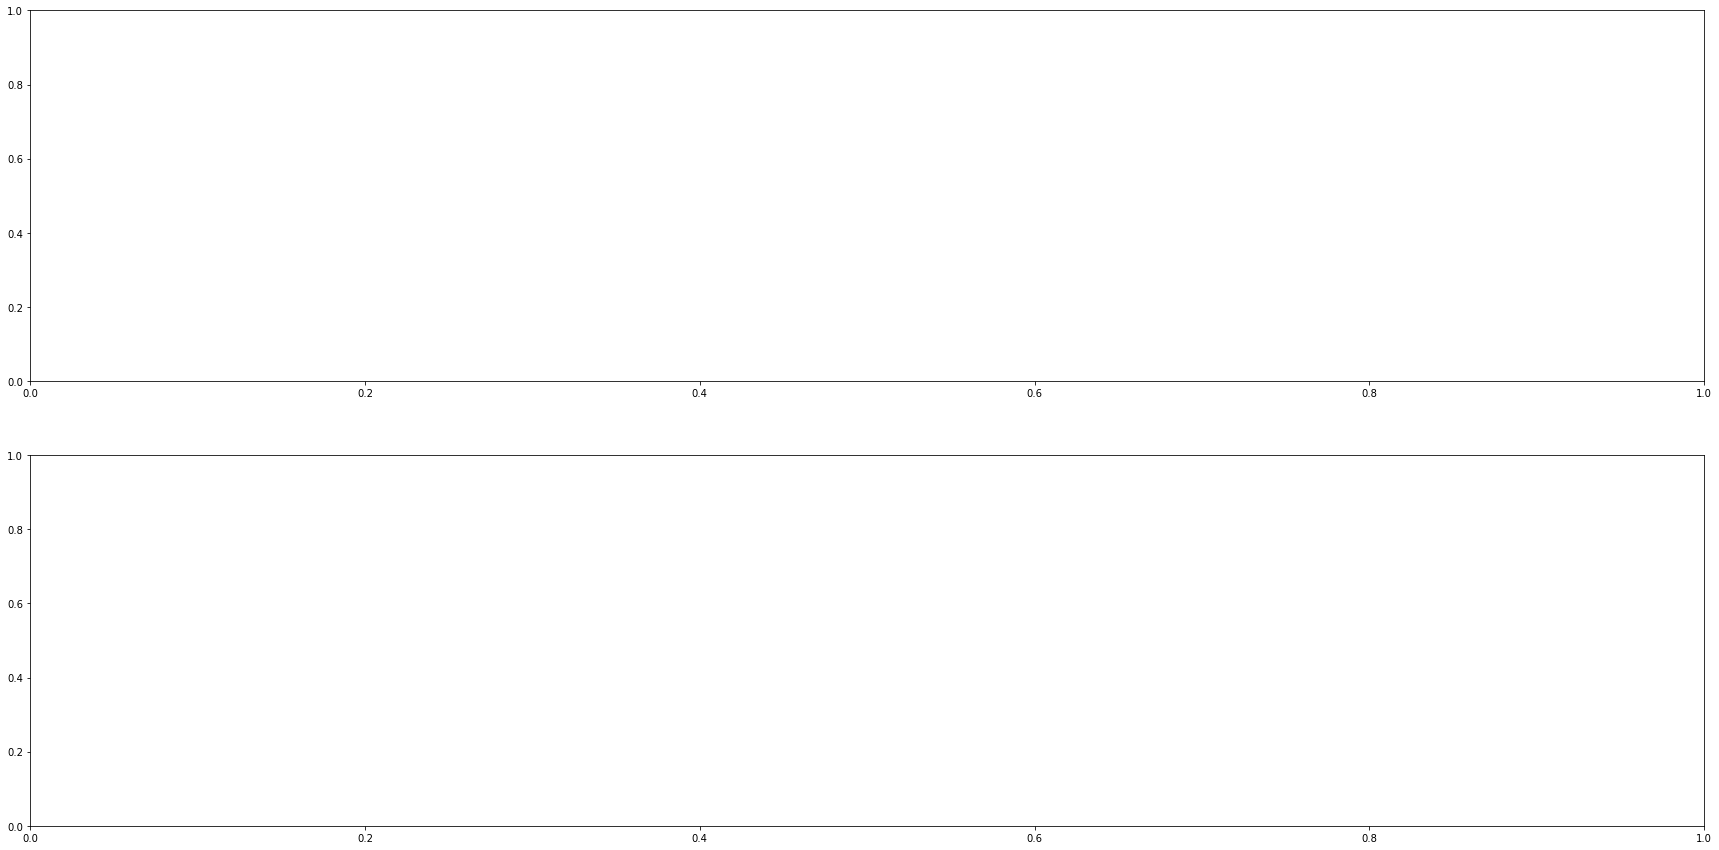

In [5]:
# use this setup so we can add the shaded boxes
fig,axs = plt.subplots(2,1, figsize=(30,15))

# timecourse
plotting.LazyPlot(func.high_passed_df[f'vox {plot_vox}'].values,
                  axs=axs[0],
                  line_width=0.5,
                  color="#000000",
                  x_label="volumes",
                  title="High pass filtering",
                  y_label="amplitude (psc)",
                  sns_trim=False,
                  x_lim=[0,avg_func[f'vox {plot_vox}'].values.shape[0]],
                  xkcd=plot_xkcd,
                  font_size=18)

plotting.LazyPlot(win11_poly3[f'vox {plot_vox}'].values,
                  axs=axs[1],
                  line_width=0.5,
                  color="#000000",
                  x_label="volumes",
                  title=f"Low+high pass filtering (SG, {window} TRs poly order {order})",
                  y_label="amplitude (psc)",
                  add_hline='default',
                  sns_trim=False,
                  x_lim=[0,avg_func[f'vox {plot_vox}'].values.shape[0]],
                  xkcd=plot_xkcd,
                  font_size=18)               

# fig.savefig(opj(func_dir, "filtering.pdf"))

Here we start to chunk up the average timecourse into the individual iterations:
- $baseline_{tr} = 30s / 0.105s \approx 285.71 $ trials. Because we're dealing with volumes and TRs, we need an integer, so let's say $286$
- Each iteration = $160$ seconds, so $160/0.25 \approx 1523.81$ trials. Again, make integer: $1524$ trials per iteration
- We have three iterations, but for some reason the number of trials exceeded the number of volumes (timing of the sequence seems difficult to predict with multi-echo acquisition..?)
- Now I loop through the number of iterations starting from $286$ with steps of $1524$.
- The final iteration doesn't have enough volumes for this operation, so it's zero-padded at the end
- The output of this is a numpy-array with shape `(1524, 720, 3)` for `(<volumes>, <n_voxels>, <iterations>)`, which is then concatenated over the last axis

Q: what to do about the baseline? There's no average for baseline, so if we add the baseline back after averaging we have a rather tumultuous beginning of the timecourse followed by smoother timecourse due to averaging

In [4]:
n_iter = 3
iter_chunks = []
start = 286
iter_size = 1524
baseline = avg_func[:start]
for ii in range(n_iter):

    
    # try to fetch values, if steps are out of bounds, zero-pad the timecourse
    if start+iter_size < avg_func.shape[0]:
        chunk = avg_func.values[start:start+iter_size]
    else:
        chunk = avg_func.values[start+iter_size:]
        padded_array = np.zeros((iter_size, 720))
        padded_array[:chunk.shape[0]] = chunk
        chunk = padded_array.copy()

    iter_chunks.append(chunk[...,np.newaxis])
    start += iter_size
    print(f"Chunk size = {chunk.shape}")

avg_iters_baseline = np.concatenate((baseline, np.concatenate(iter_chunks, axis=-1).mean(axis=-1)))
avg_iters_no_baseline = np.concatenate(iter_chunks, axis=-1).mean(axis=-1)
print(f"Final func data (w/o baseline) has shape: {avg_iters_no_baseline.shape}")

Chunk size = (1524, 720)
Chunk size = (1524, 720)
Chunk size = (1524, 720)
Final func data (w/o baseline) has shape: (1524, 720)


Here I plotted the average timecourse with the iterations marked in shaded bands

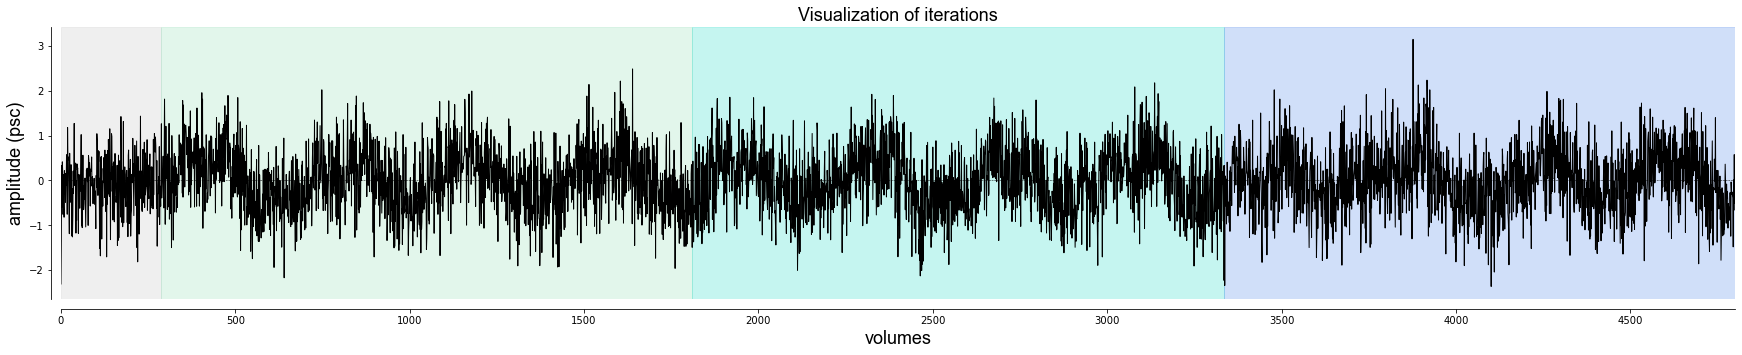

In [8]:
# use this setup so we can add the shaded boxes
fig,axs = plt.subplots(figsize=(30,5))
x = np.arange(0, len(avg_func[f'vox {plot_vox}'].values), step=1)

# shaded boxes for iterations
axs.axvspan(0, 286, alpha=0.3, color="#cccccc")
axs.axvspan(286, 286+iter_size, alpha=0.3, color="#9FE2BF")
axs.axvspan(286+iter_size, 286+(iter_size*2), alpha=0.3, color="#40E0D0")
axs.axvspan(286+(iter_size*2), avg_func.shape[0], alpha=0.3, color="#6495ED")

# timecourse
plotting.LazyPlot(avg_func[f'vox {plot_vox}'].values,
                  axs=axs,
                  line_width=1,
                  color="#000000",
                  x_label="volumes",
                  title="Visualization of iterations",
                  y_label="amplitude (psc)",
                  add_hline='default',
                  sns_trim=False,
                  xkcd=plot_xkcd,
                  x_lim=[0,avg_func[f'vox {plot_vox}'].values.shape[0]],
                  font_size=18)

# fig.savefig(opj(func_dir, "clustering.pdf"))

Below the averaged timecourses across the cortical ribbon at our target vertex without adding back the baseline

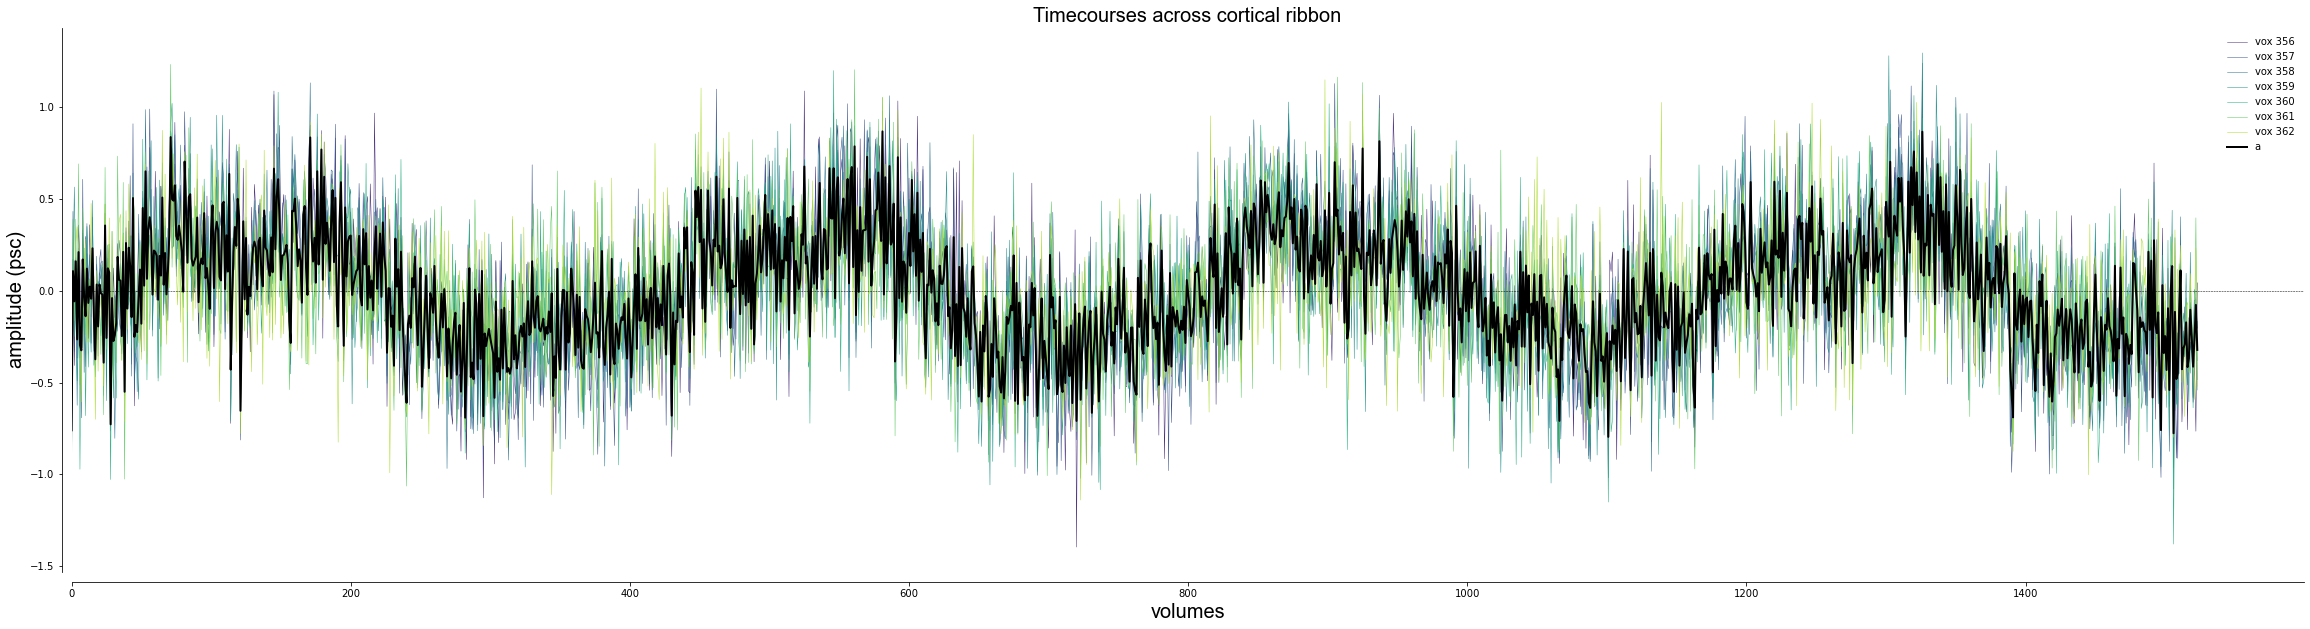

In [9]:
fig,axs = plt.subplots(figsize=(40,10))

ribbon      = [356,363]
include_vox = np.arange(*ribbon)
data = [avg_iters_no_baseline[:, ii] for ii in include_vox]

# get average across depth w/ different color
avg_ribbon = [ii[...,np.newaxis] for ii in data]
avg_ribbon = np.concatenate(avg_ribbon, axis=-1).mean(axis=-1)

labels = [f'vox {ii}' for ii in include_vox]

# plot individual voxels
plotting.LazyPlot(data,
                  axs=axs,
                  x_label="volumes",
                  y_label="amplitude (psc)",
                  title="Timecourses across cortical ribbon",
                  labels=labels,
                  add_hline='default',
                  set_xlim_zero=True,
                  sns_trim=False,
                  line_width=0.5,
                  xkcd=plot_xkcd,
                  font_size=20)

# plot average
plotting.LazyPlot(avg_ribbon,
                 axs=axs,
                 color="#000000",
                 labels='average',
                 set_xlim_zero=True,
                 sns_trim=False,
                 line_width=2,
                 xkcd=plot_xkcd,
                 font_size=20)

fig.savefig(opj(func_dir, "avg+ribbon.pdf"))

What to do about the baseline.. This is not average over iterations, only over the two pRF-runs.. So adding is back to the timecourse averaged over iterations looks a bit off..

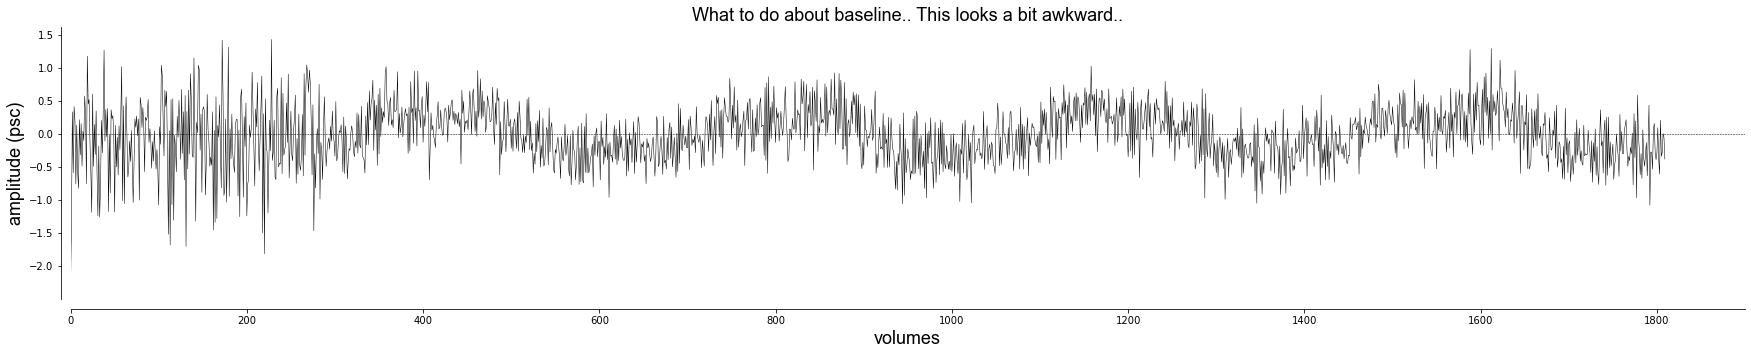

In [10]:
plotting.LazyPlot(avg_iters_baseline[:, plot_vox],
                  figsize=(30,5),
                  line_width=0.5,
                  color="#000000",
                  x_label="volumes",
                  y_label="amplitude (psc)",
                  title="What to do about baseline.. This looks a bit awkward..",
                  add_hline='default',
                  sns_trim=False,
                  set_xlim_zero=True,
                  xkcd=plot_xkcd,
                  font_size=18)

add data to `pRF`-key

In [9]:
hdf_file = opj(func_dir, 'sub-003_ses-3_bold1.h5')
if not os.path.exists(hdf_file):
    func.to_hdf('df_func_psc', hdf_file, 'pRF')

---
# pRF-fitting

Here we fetch relevant pRF-parameters that are required to construct the size-response curve below (this is the same curve as in `derivatives/pycortex/<subject>/<subject>_hemi-?_desc-prf_sizeresponse.pdf`).

In [18]:
# collect subject data including Normalization parameters
cx_dir = opj(project_dir, 'hemifield', 'derivatives', 'pycortex', f"sub-{sub}")
prf_old = opj(project_dir, 'hemifield', 'derivatives', 'prf', f"sub-{sub}", 'ses-1')
subject_info = utils.CollectSubject(f"sub-{sub}", 
                                    prf_dir=prf_old, 
                                    cx_dir=cx_dir, 
                                    settings='recent', 
                                    hemi="lh", 
                                    model="norm")

# initiate the SizeResponse class
SR = prf.SizeResponse(subject_info.prf_stim, subject_info.normalization_params, subject_info=subject_info)

# make the stimuli
SR.make_stimuli()

# make the curve
sr_curve1 = SR.make_sr_function(center_prf=True)

# stimsizes are in SR.stims_fill_sizes

Using settings file: /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-1/20220210_model-norm_desc-settings.yml


Create the design matrix

In [12]:
# line pRF
log_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/prf_design/sub-003_ses-0_task-pRF_run-0"
design = prf.create_line_prf_matrix(log_dir, 
                                    stim_duration=0.25,
                                    nr_trs=avg_iters_baseline.shape[0],
                                    TR=0.105,
                                    verbose=True)

print(design.shape)

Reading onset times from log-file

EXPTOOLS
 1st 't' @42.19s
 Cutting 42.19s from onsets
Creating design matrix (can take a few minutes with thousands of TRs)
(270, 270, 1810)


In [13]:
design = design[...,286:]
design.shape

(270, 270, 1524)

# Fit on highpass zscore data

In [16]:
ribbon_func = np.array(data)
use_model = "norm"

zscore_fit = prf.pRFmodelFitting(ribbon_func, 
                                 design_matrix=design, 
                                 TR=0.105, 
                                 model=use_model, 
                                 stage='grid+iter', 
                                 verbose=True, 
                                 write_files=False)
zscore_fit.fit()

Starting gauss grid fit at 2022/03/06 17:40:48
Gaussian gridfit completed at 2022/03/06 17:41:47. voxels/vertices above 0.1: 7 out of 7
Gridfit took 0:00:59.196478
Mean rsq>0.1: 0.2565019726753235
Starting gauss iterfit at 2022/03/06 17:41:47
Gaussian iterfit completed at 2022/03/06 17:41:51. Mean rsq>0.1: 0.25761568537738416
Iterfit took 0:00:03.584625
Using settings file: /mnt/export/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/notebooks/prf/20220306_model-norm_desc-settings.yml
Starting norm grid fit at 2022/03/06 17:41:52


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   19.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   19.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   19.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   19.3s finished


Norm gridfit completed at 2022/03/06 17:42:11. Mean rsq>0.1: 0.3066316140549524
Gridfit took 0:00:19.330752
Starting norm iterfit at 2022/03/06 17:42:11
Norm iterfit completed at 2022/03/06 18:21:27. Mean rsq>0.1: 0.30873698078015027
Iterfit took 0:39:16.042374


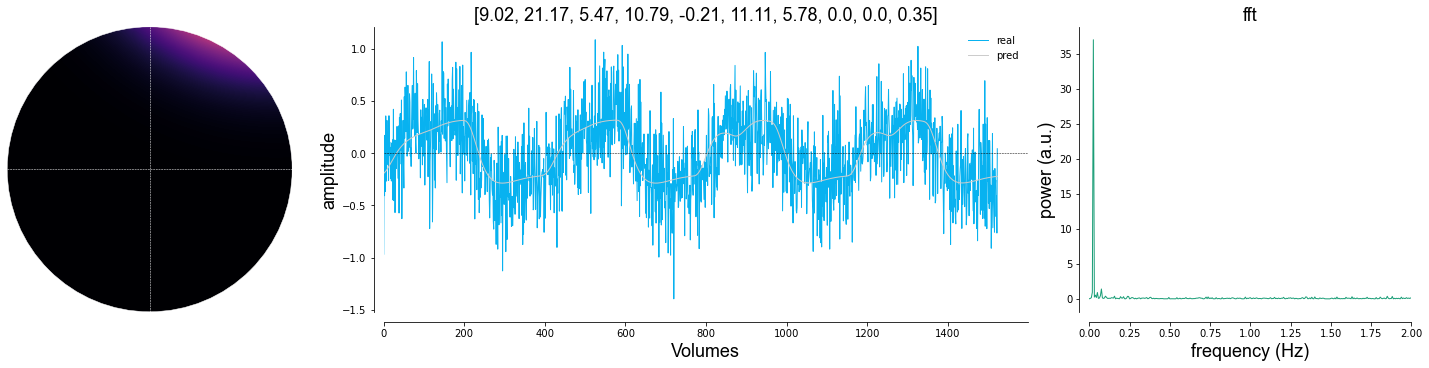

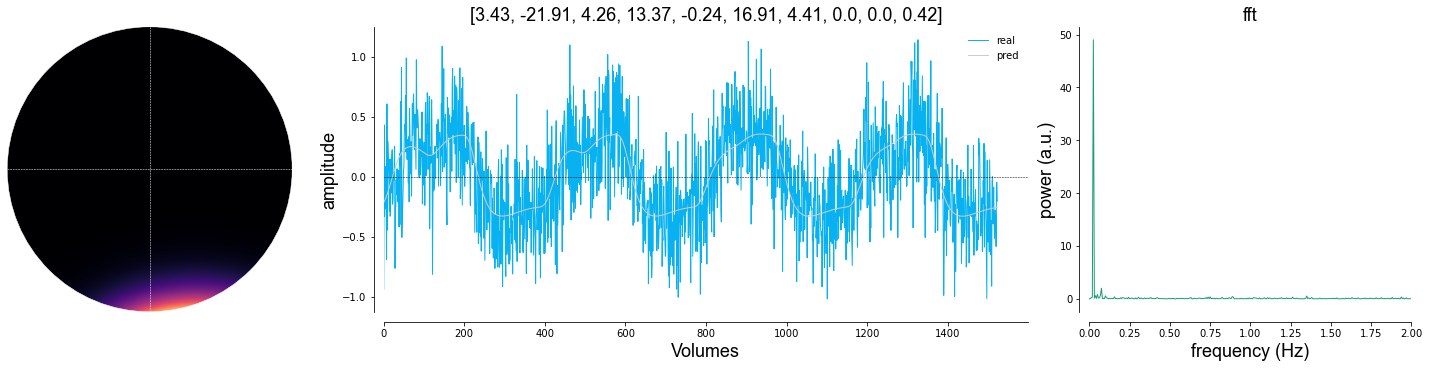

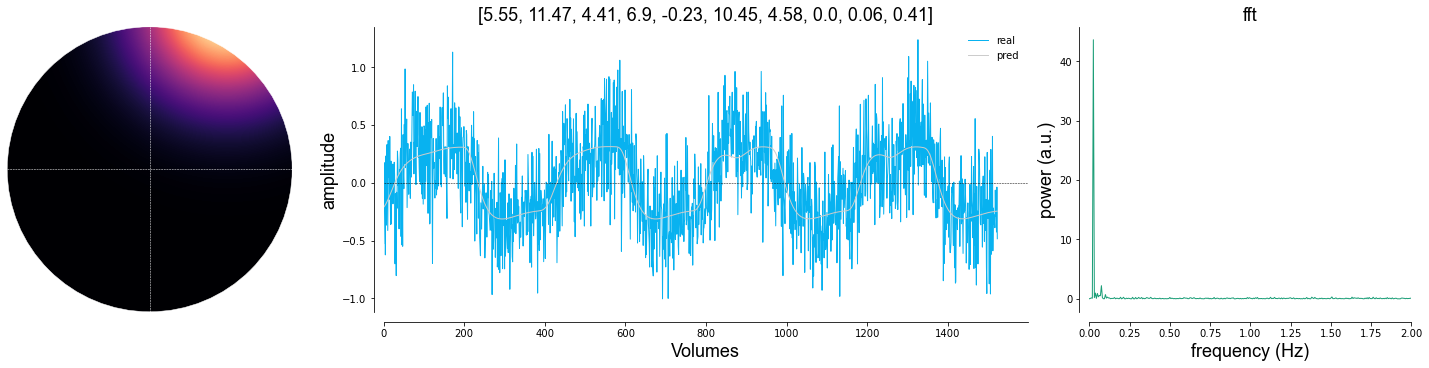

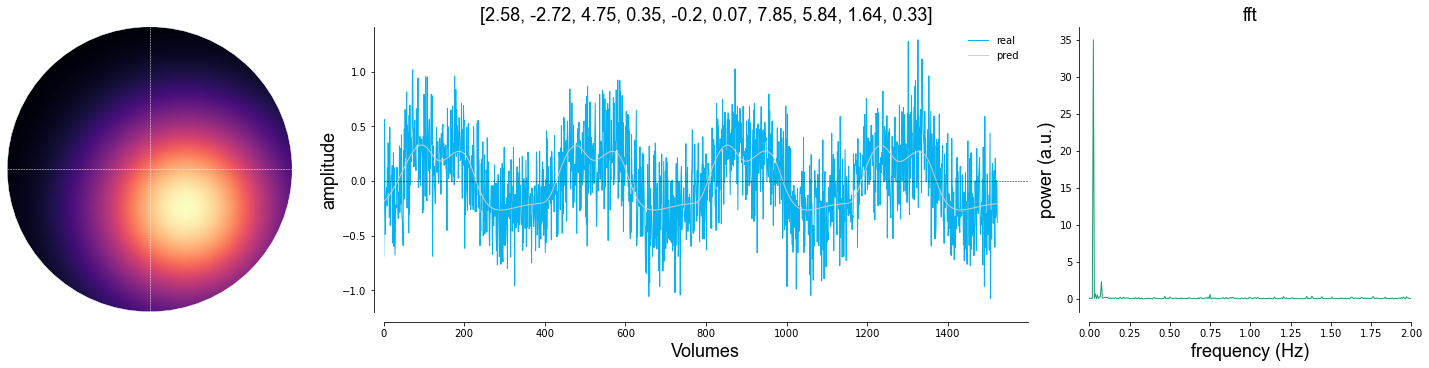

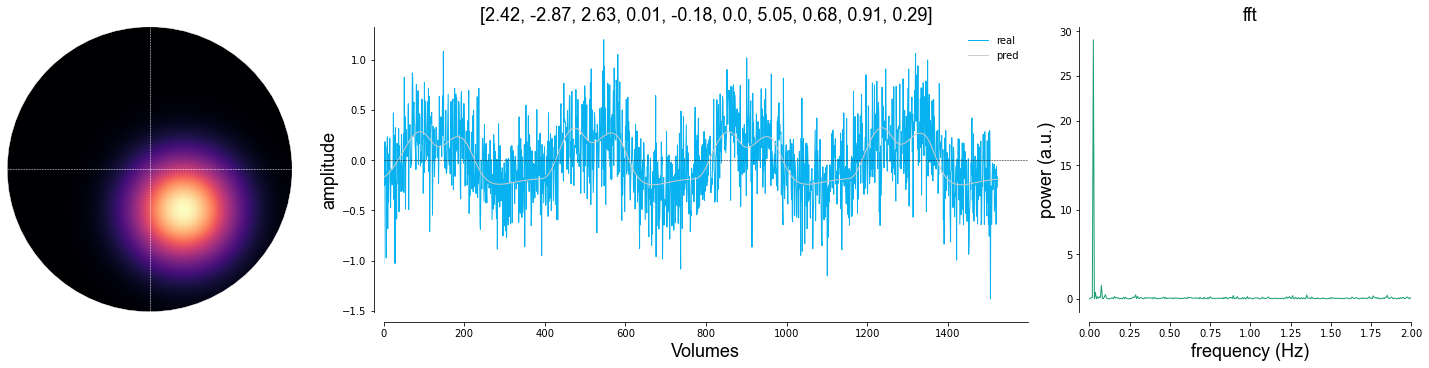

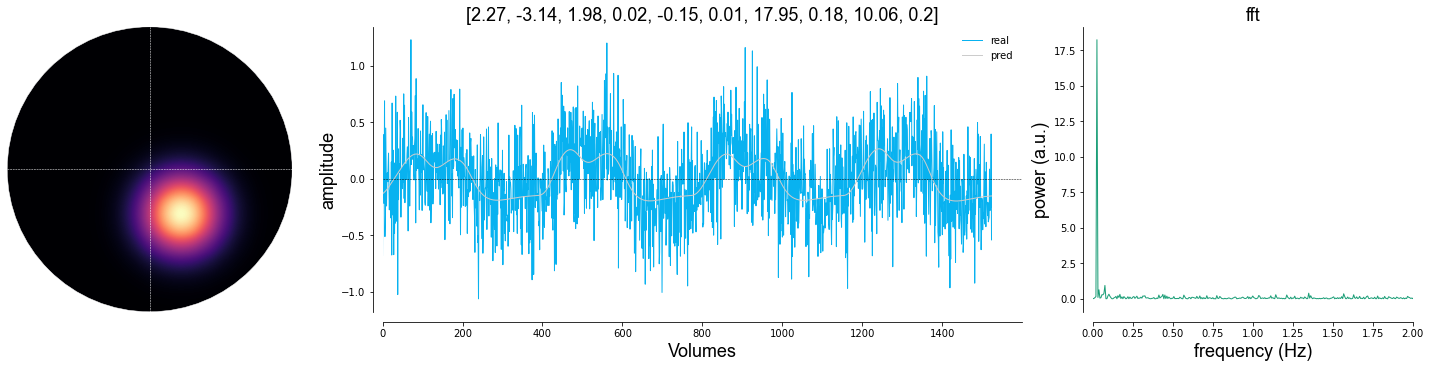

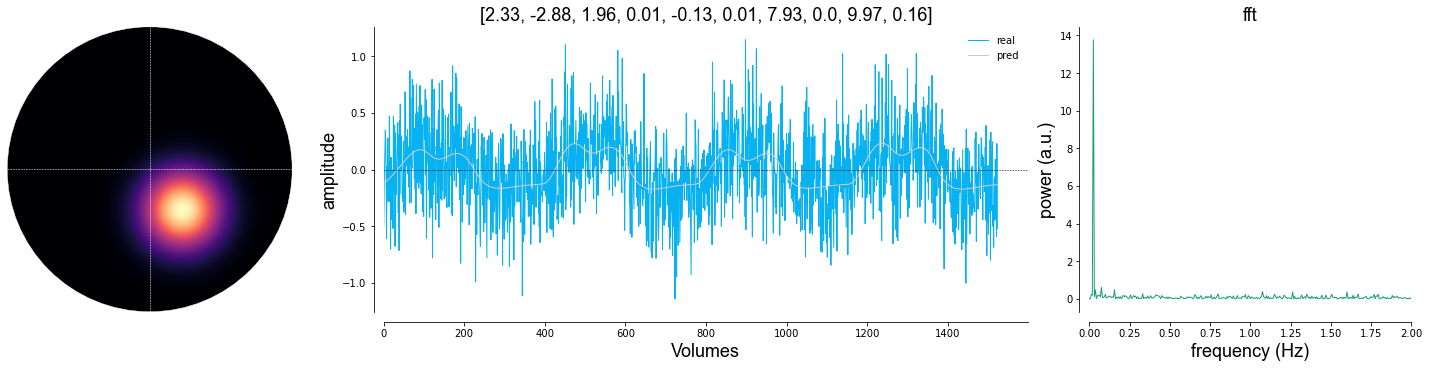

In [17]:
for vox_id in range(len(ribbon_func)):
    pars,_,_ = zscore_fit.plot_vox(vox_nr=vox_id, model='norm', xkcd=False, title='pars', transpose=False, freq_spectrum=True, freq_type="fft")

In [15]:
# start = 280
# stop = 360
# f, ss = plt.subplots(1,(stop-start),figsize=(30,10))
# for x in range(start,stop):
#     ss[x-start].imshow(design[...,x])
#     ss[x-start].axis('off')

## Fit partial FOV data > run with `pRFline/scripts/partial.fit.py`

In [26]:
prf_pfov = opj(prf_new, "sub-003_ses-3_task-pRF_acq-3DEPI_model-gauss_stage-iter_desc-prf_params.npy")
if not os.path.exists(prf_pfov):
    print(f"Running fit")
    # modelling_pfov = prf.pRFmodelFitting(partial_nan.T, 
    #                                      design_matrix=design_pfov, 
    #                                      TR=pfov_TR, 
    #                                      model='norm', 
    #                                      stage='grid+iter', 
    #                                      verbose=True,
    #                                      output_dir=prf_new,
    #                                      output_base="sub-003_ses-3_task-pRF_acq-3DEPI",
    #                                      write_files=True)

    # modelling_pfov.fit()
else:
    print(f"Loading parameter file {prf_pfov}")
    yml = utils.get_file_from_substring("settings", prf_new)
    if isinstance(yml, list):
        yml = yml[-1]

    model = "gauss"
    modelling_pfov = prf.pRFmodelFitting(partial_nan.T,
                                         design_matrix=design_pfov,
                                         settings=yml,
                                         model=model,
                                         output_dir=prf_new,
                                         output_base="sub-003_ses-3_task-pRF_acq-3DEPI")

    modelling_pfov.load_params(np.load(prf_pfov), model=model, stage='iter', acq="3DEPI")

Loading parameter file /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/sub-003_ses-3_task-pRF_acq-3DEPI_model-gauss_stage-iter_desc-prf_params.npy
Using settings file: /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/20220220_model-norm_desc-settings.yml


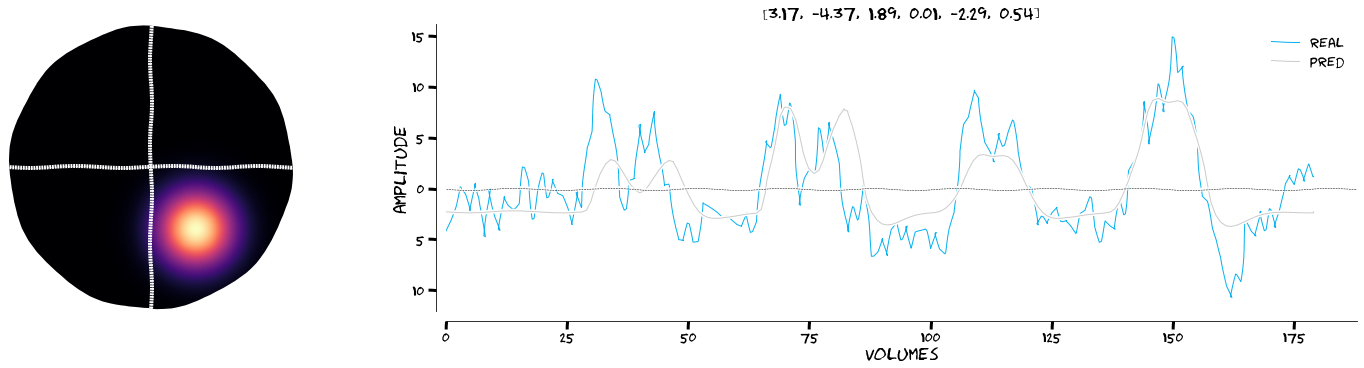

In [27]:
pars,_,_ = modelling_pfov.plot_vox(vox_nr=336, model='gauss', xkcd=plot_xkcd, title='pars', transpose=False)

## Fit Line data

Perform a pRF-fit on the average across ribbon to use as starting point for the individual voxels

In [130]:
# add dimension
if avg_ribbon.ndim < 2:
    avg_ribbon = avg_ribbon[np.newaxis,...]

use_model = "norm"
print(f"Running fit")

avg_fit = prf.pRFmodelFitting(avg_ribbon, 
                              design_matrix=design, 
                              TR=0.105, 
                              model=use_model, 
                              stage='grid+iter', 
                              verbose=True, 
                              write_files=False)

avg_fit.fit()

Running fit
Starting gauss grid fit at 2022/02/21 19:10:54
Gaussian gridfit completed at 2022/02/21 19:11:42. voxels/vertices above 0.1: 1 out of 1
Gridfit took 0:00:47.477872
Mean rsq>0.1: 0.708801805973053
Starting gauss iterfit at 2022/02/21 19:11:42
Gaussian iterfit completed at 2022/02/21 19:11:44. Mean rsq>0.1: 0.7088018315460334
Iterfit took 0:00:01.725100
Using settings file: /mnt/export/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/notebooks/prf/20220221_model-norm_desc-settings.yml
Starting norm grid fit at 2022/02/21 19:11:44


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Norm gridfit completed at 2022/02/21 19:11:47. Mean rsq>0.1: 0.8297953009605408
Gridfit took 0:00:02.702466
Starting norm iterfit at 2022/02/21 19:11:47
Norm iterfit completed at 2022/02/21 19:17:44. Mean rsq>0.1: 0.8326833815787503
Iterfit took 0:05:56.535387


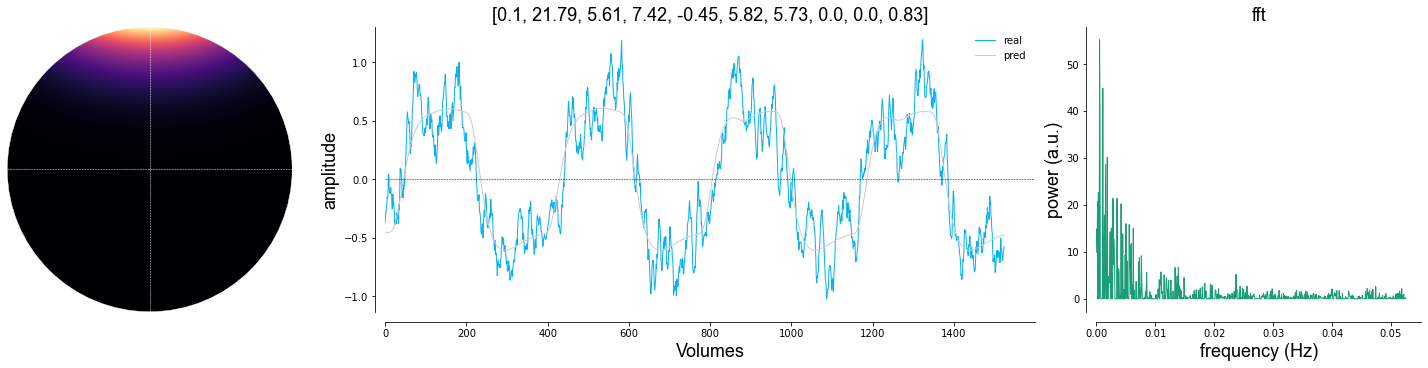

In [131]:
pars,_,_ = avg_fit.plot_vox(vox_nr=0, model='norm', xkcd=False, title='pars', transpose=False, freq_spectrum=True, freq_type="fft")

In [14]:
ribbon_func = np.array(data)
use_model = "norm"

prf_lines = opj(prf_new, "sub-003_ses-3_task-pRF_model-norm_stage-iter_desc-prf_params.npy")
if not os.path.exists(prf_lines):
    print(f"Running fit")
    modelling = prf.pRFmodelFitting(ribbon_func, 
                                    design_matrix=design, 
                                    TR=0.105, 
                                    model=use_model, 
                                    stage='grid+iter', 
                                    verbose=True, 
                                    output_dir=prf_new,
                                    output_base="sub-003_ses-3_task-pRF",
                                    write_files=True)

    modelling.fit()
else:
    print(f"Loading parameter file {prf_lines}")
    yml = utils.get_file_from_substring([use_model, "settings"], prf_new)
    if isinstance(yml, list):
        yml = yml[-1]

    modelling = prf.pRFmodelFitting(ribbon_func,
                                    design_matrix=design,
                                    settings=yml,
                                    TR=0.105,
                                    model=use_model,
                                    output_dir=prf_new,
                                    output_base="sub-003_ses-3_task-pRF")

    modelling.load_params(np.load(prf_lines), model=use_model, stage='iter', acq='line')

Loading parameter file /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/sub-003_ses-3_task-pRF_model-norm_stage-iter_desc-prf_params.npy
Using settings file: /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/20220220_model-norm_desc-settings.yml


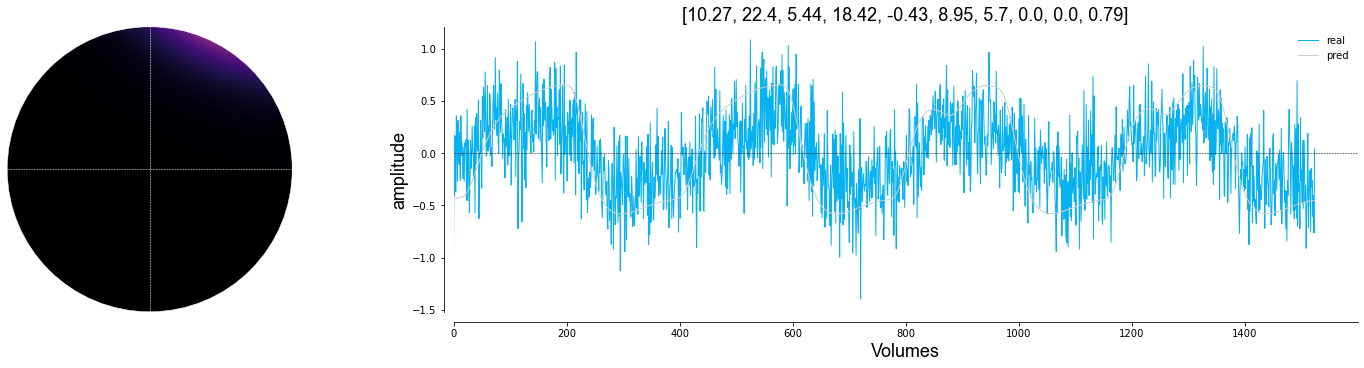

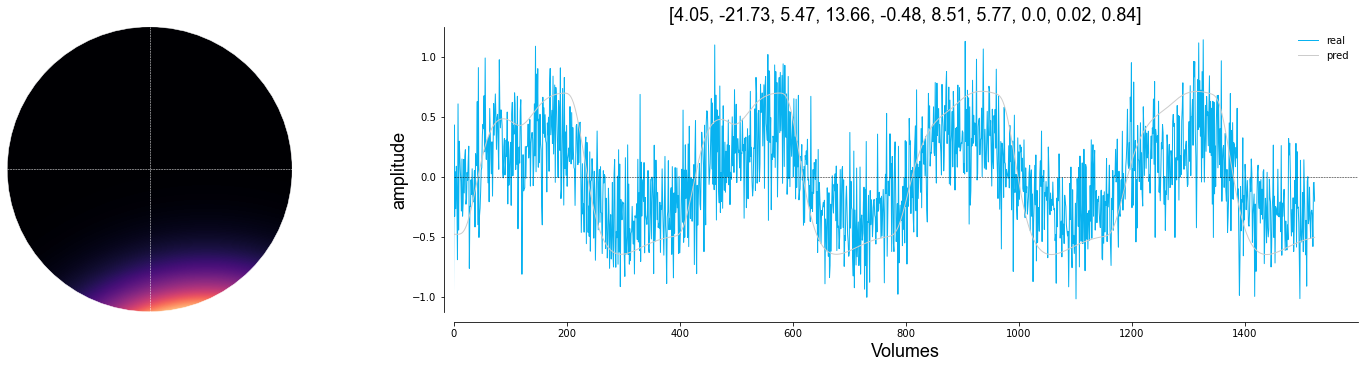

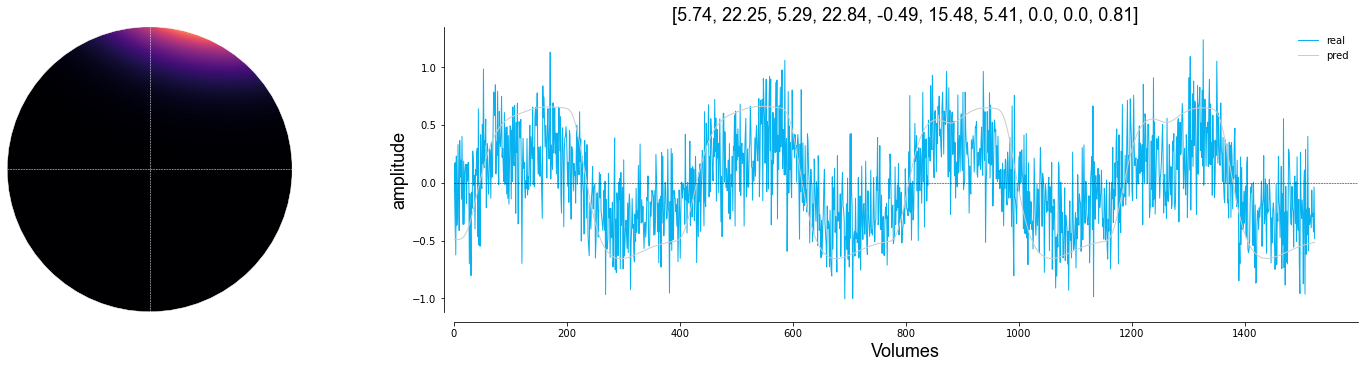

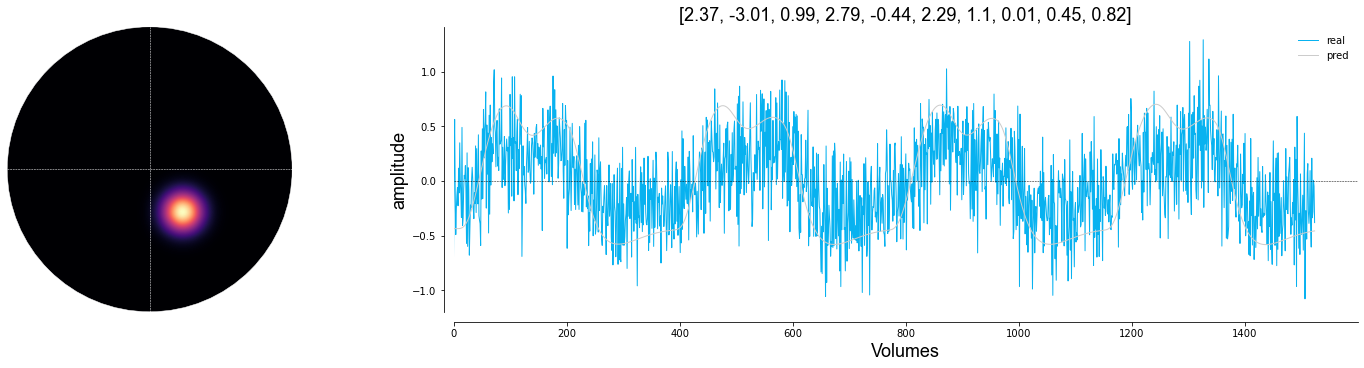

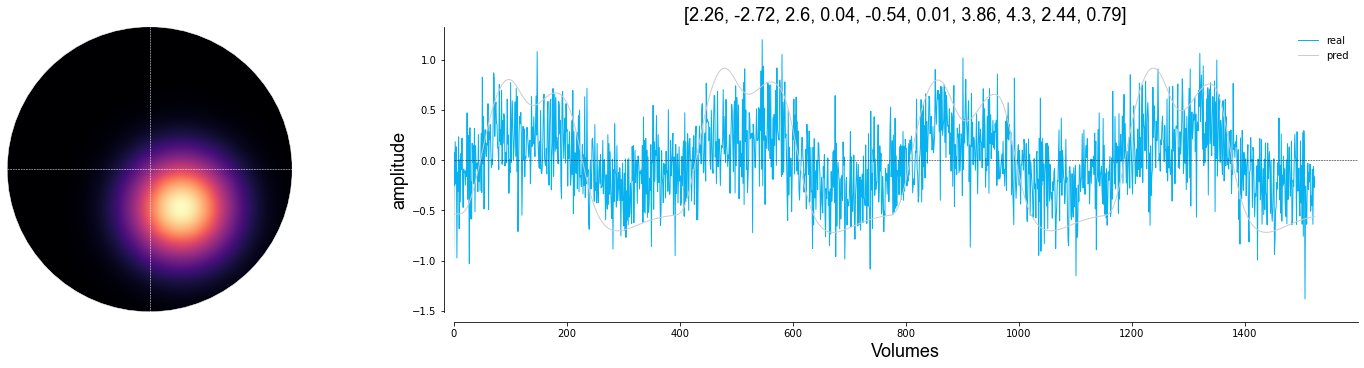

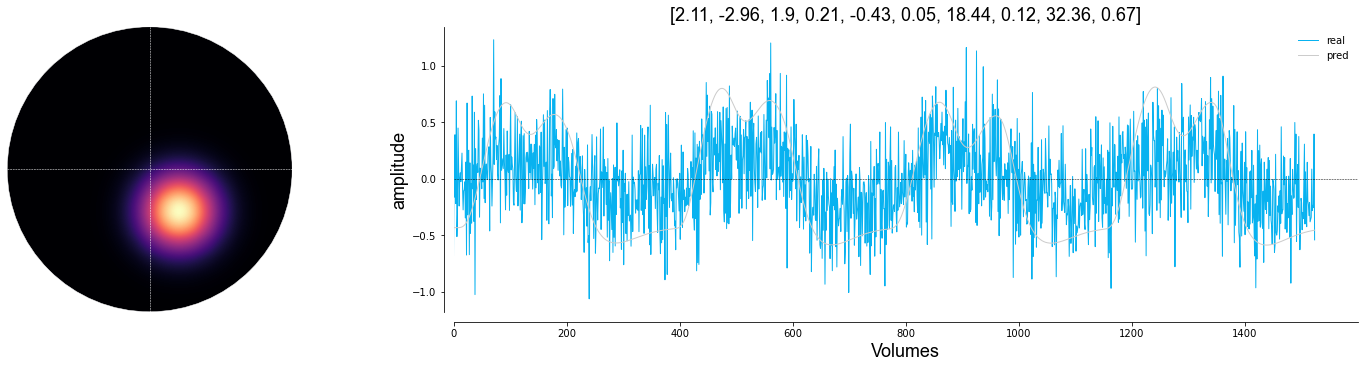

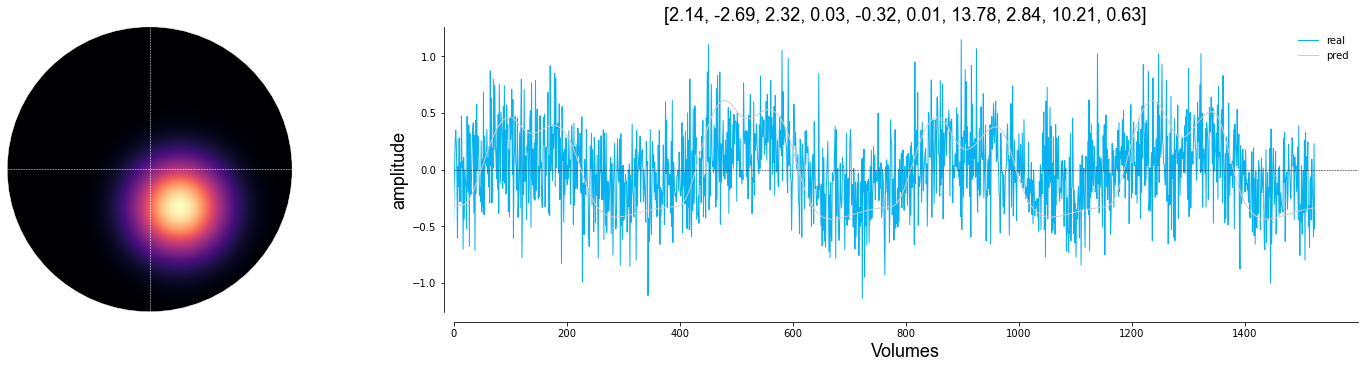

In [31]:
for vox_id in range(len(ribbon_func)):
    fname = opj(prf_new, f"prf_vox-{vox_id}.{fig_ext}")
    pars,_,_ = modelling.plot_vox(vox_nr=vox_id, model='norm', xkcd=False, title='pars', transpose=False, save_as=fname)

Session 1 - pRF prediction/location:

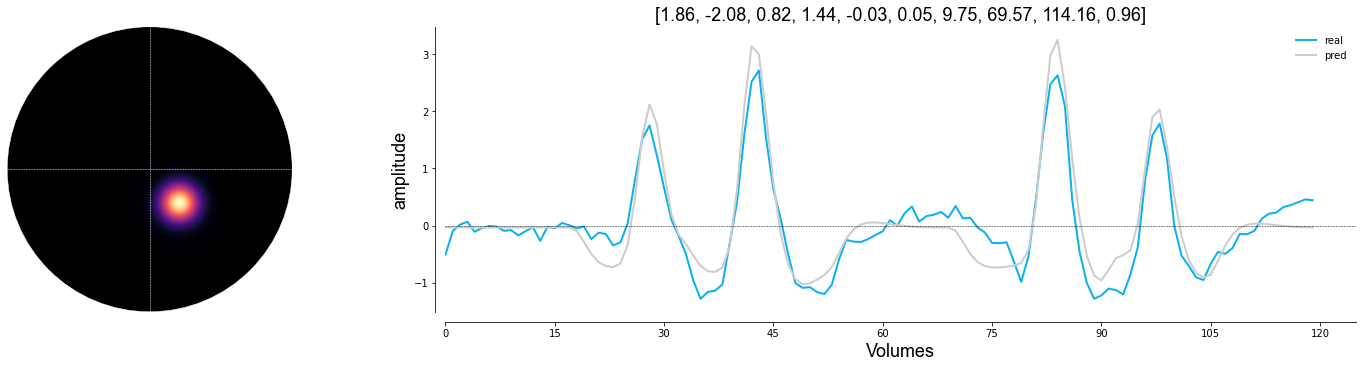

In [30]:
subject_info.target_prediction_prf(xkcd=False, line_width=2, save_as=opj(prf_new, f"prf_vox-target.{fig_ext}"))

In [29]:
prf_new

'/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3'

`Vox 359` looks rather similar compared to our target vertex, which is sort of what we wanted. Below I created binary representations of both pRFs for an overlap image

Distance of centers between target pRF and line PRF = 1.06 dva


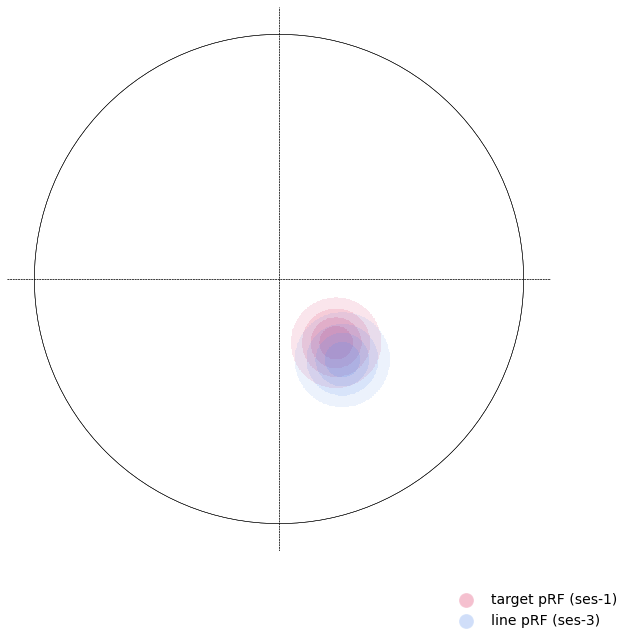

In [36]:
# get linescanning pRF 
vox_id = utils.find_nearest(include_vox, plot_vox)[0]
pars = modelling.norm_iter[vox_id,...]
prf_line = prf.make_prf(modelling.prf_stim, size=pars[2], mu_x=pars[0], mu_y=pars[1])

# get target pRF from ses-1
prf_target = subject_info.prf_array.copy()

# create different colormaps
colors = ["#DE3163", "#6495ED"]
cmap1 = utils.make_binary_cm(colors[0])
cmap2 = utils.make_binary_cm(colors[1])
cmaps = [cmap1, cmap2]

# initiate and plot figure
fig,axs = plt.subplots(figsize=(10,10 ))
for ix, obj in enumerate([prf_target,prf_line]):
    plotting.LazyPRF(obj, 
                    vf_extent=subject_info.settings['vf_extent'], 
                    ax=axs, 
                    cmap=cmaps[ix], 
                    cross_color='k', 
                    alpha=0.5, 
                    xkcd=plot_xkcd,
                    shrink_factor=0.9)

# get distance of pRF-centers
dist = prf.distance_centers(subject_info.target_params, pars)
print(f"Distance of centers between target pRF and line PRF = {round(dist, 2)} dva")

# create custom legend
legend_elements = [Line2D([0],[0], marker='o', color='w', label='target pRF (ses-1)', mfc=colors[0], markersize=15, alpha=0.3),
                   Line2D([0],[0], marker='o', color='w', label='line pRF (ses-3)', mfc=colors[1], markersize=15, alpha=0.3)]

# formatting
if plot_xkcd:
    font = "Humor Sans"
else:
    font = "Arial"

L = fig.legend(handles=legend_elements, frameon=False, fontsize=14, loc='lower right')
plt.setp(L.texts, family='Humor Sans')

# overarching title
# fig.suptitle(f"Overlap between target pRF and pRF of line-acquisition (vox {plot_vox})", fontsize=20, fontname=font)

# save img
img = opj(prf_new, f'prf_overlap.{fig_ext}')
fig.savefig(img)
plt.show()

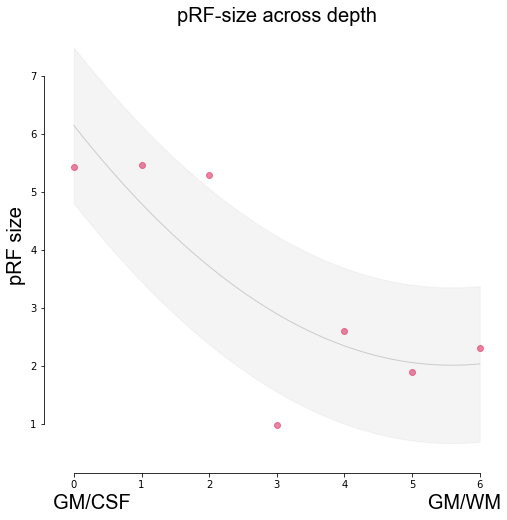

In [38]:
fig, axs = plt.subplots(figsize=(8,8))

prf_size = modelling.norm_iter[...,2]
cf = utils.CurveFitter(prf_size, order=2, verbose=False)

axs.plot(cf.x, prf_size, 'o', color=colors[0], alpha=0.6)
plotting.LazyPlot(cf.y_pred_upsampled,
                  xx=cf.x_pred_upsampled,
                  error=cf.ci_upsampled,
                  axs=axs,
                  color="#cccccc",
                  error_alpha=0.2,
                  x_label="GM/CSF                                                      GM/WM",
                  y_label="pRF size",
                  title="pRF-size across depth",
                  set_xlim_zero=False,
                  sns_trim=True,
                  line_width=1,
                  xkcd=plot_xkcd,
                  font_size=20)

# save img
img = opj(prf_new, f'prf_depth.{fig_ext}')
fig.savefig(img)